In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_pickle('data/1min.pkl')
df.head()

,date,pressure,temperature,humidity,so2,h2s,h2s_ref,captor
0,2016-05-23 08:30:00,1017,24.0,42.0,0.0,"[14, 13, 14, 13, 14, 13, 14, 13, 14, 14, 16, 1...",0.0,1303
1,2016-05-23 08:45:00,1017,24.0,42.0,0.0,"[13, 14, 16, 16, 17, 16, 14, 16, 15, 16, 14, 1...",0.0,1303
2,2016-05-23 09:00:00,1017,24.0,42.0,0.0,"[17, 13, 14, 13, 15, 15, 15, 16, 15, 14, 16, 1...",0.0,1303
3,2016-05-23 09:15:00,1017,24.0,42.0,0.0,"[13, 13, 15, 15, 15, 15, 15, 16, 16, 15, 16, 1...",0.0,1303
4,2016-05-23 09:30:00,1017,24.0,42.0,0.0,"[15, 16, 15, 14, 16, 15, 14, 13, 14, 16, 13, 1...",0.0,1303


In [3]:
def split_dataframe(dataframe, percent):
    nb_rows = int(np.floor(percent * len(dataframe)))
    return dataframe[:nb_rows], dataframe[nb_rows:]

def dataframe_to_xy_with_ref(df):
    return (np.array(df[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, \
                         'h2s_ref', 'pressure', 'temperature', 'humidity']]),\
            np.array(df['so2']))

def dataframe_to_xy_without_ref(df):
    return (np.array(df[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, \
                         'pressure', 'temperature', 'humidity']]),\
            np.array(df['so2']))

df = df.reset_index()
df = df[pd.notnull(df).all(axis=1)]
df = df.reindex(np.random.permutation(df.index))

In [4]:
df_test, df_train = split_dataframe(df, 0.5) 
df_valid, df_test = split_dataframe(df_test, 0.5)

In [5]:
data = df_train['h2s']

store = []
for i in range(len(data)):
    store += [n for n in data.iloc[i]]

mean_h2s = np.mean(store)
std_h2s = np.std(store)

df_train[['h2s']] = data.apply(lambda x: [(n - mean_h2s)/std_h2s for n in x])
data = df_valid['h2s']
df_valid[['h2s']] = data.apply(lambda x: [(n - mean_h2s)/std_h2s for n in x])
data = df_test['h2s']
df_test[['h2s']] = data.apply(lambda x: [(n - mean_h2s)/std_h2s for n in x])

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [6]:
tmp_df = df_train[['pressure', 'temperature', 'humidity', 'h2s_ref']]
normalized_df = (tmp_df - tmp_df.mean()) / tmp_df.std()
df_train[['pressure', 'temperature', 'humidity', 'h2s_ref']] = normalized_df
df_train = pd.concat([df_train, df_train['h2s'].apply(pd.Series)], axis=1)

tmp_df = df_valid[['pressure', 'temperature', 'humidity', 'h2s_ref']]
normalized_df = (tmp_df - tmp_df.mean()) / tmp_df.std()
df_valid[['pressure', 'temperature', 'humidity', 'h2s_ref']] = normalized_df
df_valid = pd.concat([df_valid, df_valid['h2s'].apply(pd.Series)], axis=1)

tmp_df = df_test[['pressure', 'temperature', 'humidity', 'h2s_ref']]
normalized_df = (tmp_df - tmp_df.mean()) / tmp_df.std()
df_test[['pressure', 'temperature', 'humidity', 'h2s_ref']] = normalized_df
df_test = pd.concat([df_test, df_test['h2s'].apply(pd.Series)], axis=1)

/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:2352: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


# Apprentissage avec H2S_ref

In [7]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

def baseline_model(dense_size, input_dim, loss_function, optimizer):
    # create model
    model = Sequential()
    model.add(Dense(dense_size, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss=loss_function, optimizer=optimizer)
    model.summary()
    return model

Using TensorFlow backend.


In [8]:
X_train, y_train = dataframe_to_xy_with_ref(df_train)
X_valid, y_valid = dataframe_to_xy_with_ref(df_valid)
X_test, y_test = dataframe_to_xy_with_ref(df_test)

In [9]:
model = baseline_model(32, X_train.shape[1], 'mse', 'adamax')
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, mode='auto', patience=10)
history = model.fit(X_train, y_train, batch_size=32, epochs=1000, validation_data=(X_valid, y_valid), callbacks=[early_stopping], verbose=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                640       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 673
Trainable params: 673
Non-trainable params: 0
_________________________________________________________________
Epoch 00177: early stopping


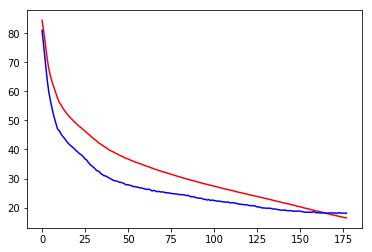

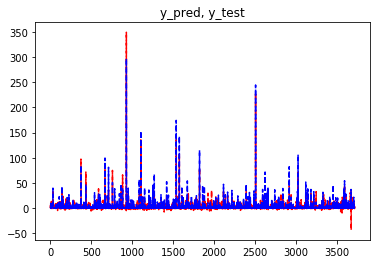

0.788888888889


In [10]:
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
plt.plot(history.history['loss'], 'r-')
plt.plot(history.history['val_loss'], 'b-')
plt.show()

plt.title('y_pred, y_test')

plt.plot(y_pred[:], '--r')
plt.plot(y_test[:], '--b')
plt.show()
percent_high_detected = np.sum(y_pred.reshape((len(y_pred), )) > 20) / np.sum(y_test.reshape((len(y_test), )) > 20)
print(percent_high_detected)
np.savetxt('out/nn_preds_h2s_ref.out', (y_test, y_pred[:, 0]))   # x,y,z equal sized 1D arrays

In [11]:
X_train, y_train = dataframe_to_xy_without_ref(df_train)
X_valid, y_valid = dataframe_to_xy_without_ref(df_valid)
X_test, y_test = dataframe_to_xy_without_ref(df_test)

In [12]:
model = baseline_model(32, X_train.shape[1], 'mse', 'adamax')
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, mode='auto', patience=10)
history = model.fit(X_train, y_train, batch_size=32, epochs=1000, validation_data=(X_valid, y_valid), callbacks=[early_stopping], verbose=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                608       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________
Epoch 00231: early stopping


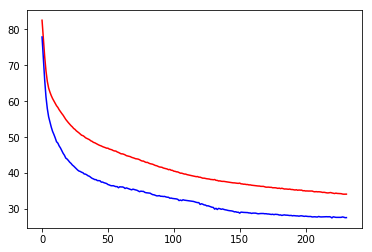

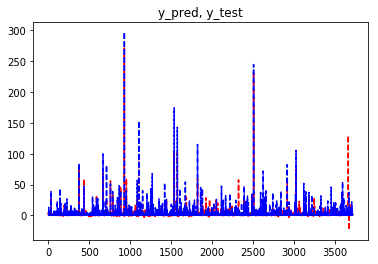

0.477777777778


In [13]:
y_pred = model.predict(X_test)
plt.plot(history.history['loss'], 'r-')
plt.plot(history.history['val_loss'], 'b-')
plt.show()

plt.title('y_pred, y_test')

plt.plot(y_pred[:], '--r')
plt.plot(y_test[:], '--b')
plt.show()
percent_high_detected = np.sum(y_pred.reshape((len(y_pred), )) > 20) / np.sum(y_test.reshape((len(y_test), )) > 20)
print(percent_high_detected)
np.savetxt('out/nn_preds_without_h2s.out', (y_test, y_pred[:, 0]))   # x,y,z equal sized 1D arrays

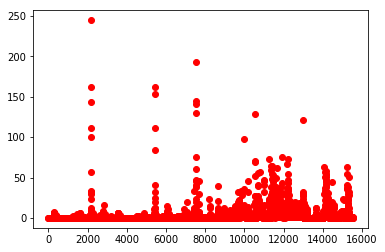

In [17]:
import matplotlib.pyplot as plt
plt.plot(df_train['so2'], 'ro')
plt.show()

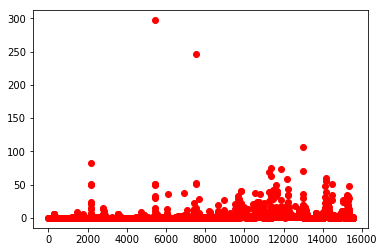

In [18]:
plt.plot(df_valid['so2'], 'ro')
plt.show()

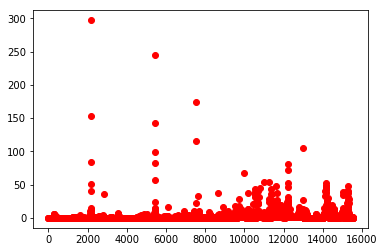

In [19]:
plt.plot(df_test['so2'], 'ro')
plt.show()